### Exercise 43

#### Import

In [1]:
import numpy as np
from numpy.linalg import det, inv
from scipy.stats import norm
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#### Data

In [2]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

X = X[y < 2]
y = y[y < 2]

n = len(y)
X = np.column_stack((np.ones(n), X))
p = len(X[0])

#### Principal component analysis (PCA)

In [4]:
pca = PCA(n_components=2)
pca_fit = pca.fit(X)

M = pca.components_
M

array([[-0.        ,  0.32327447, -0.17121498,  0.86913407,  0.33284383],
       [-0.        ,  0.65835816,  0.74710188, -0.08837738, -0.02434645]])

### Find the components directly via the spectral theorem

In [5]:
SS = (1 / (n - 1)) * (X - np.mean(X, axis=0)).T @ (X - np.mean(X, axis=0))
MSMT = M @ SS @ M.T

In [6]:
lambdas, U = np.linalg.eigh(SS)
lambdas

array([0.        , 0.01046467, 0.05123085, 0.22795013, 2.77191092])

In [7]:
U

array([[ 1.        ,  0.        ,  0.        ,  0.        , -0.        ],
       [ 0.        ,  0.09641117,  0.67287668,  0.65835816, -0.32327447],
       [ 0.        , -0.10310285, -0.63395111,  0.74710188,  0.17121498],
       [ 0.        , -0.40254057, -0.27341635, -0.08837738, -0.86913407],
       [ 0.        ,  0.9044533 , -0.26568112, -0.02434645, -0.33284383]])

In [8]:
lambdas

array([0.        , 0.01046467, 0.05123085, 0.22795013, 2.77191092])

#### Plot data after PCA

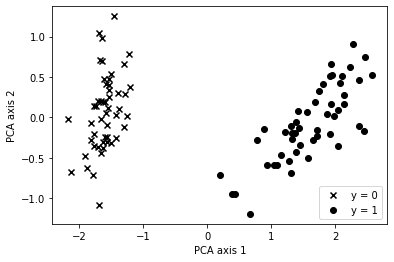

In [9]:
plt.scatter(pca.fit_transform(X)[:, 0][y == 0], pca.fit_transform(X)[:, 1][y == 0], 
            color='black', marker='x', label='y = 0')
plt.scatter(pca.fit_transform(X)[:, 0][y == 1], pca.fit_transform(X)[:, 1][y == 1], 
            color='black', label='y = 1')
plt.legend(loc='lower right')
plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')
plt.savefig('PCA_iris.pdf', format='pdf')

#### Get plotting limits (used later)

In [10]:
x_lim_lower = np.min(pca.fit_transform(X)[:, 0]) - .2
x_lim_upper = np.max(pca.fit_transform(X)[:, 0]) + .2
y_lim_lower = np.min(pca.fit_transform(X)[:, 1]) - .2
y_lim_upper = np.max(pca.fit_transform(X)[:, 1]) + .2

#### Prior

In [11]:
m0 = np.zeros(p)
alpha = .01 # Isotropic Gaussian prior
S0 = alpha**(-1) * np.eye(p)

#### Newton-Raphson

In [12]:
def f(w):
    f1 = -.5 * (w - m0).T @ inv(S0) @ (w - m0)
    f2 = 0
    for i in range(n):
        eta = w.T @ X[i]
        f2 += y[i]*norm().logcdf(eta) + (1 - y[i]) * norm().logsf(eta)
    return f1 + f2


def grad(w):
    f1 = - inv(S0) @ (w - m0)
    f2 = 0
    for i in range(n):
        eta = w.T @ X[i]
        if y[i] == 0:
            log_coeff = norm().logpdf(eta) - norm().logsf(eta)
            f2 -= np.exp(log_coeff) * X[i]
        if y[i] == 1:
            log_coeff = norm().logpdf(eta) - norm().logcdf(eta)
            f2 += np.exp(log_coeff) * X[i]
    return f1 + f2


def fisher(w):
    f1 = inv(S0)
    f2 = 0
    for i in range(n):
        eta = w.T @ X[i]
        log_coeff = 2 * norm().logpdf(eta) - norm().logcdf(eta) - norm().logsf(eta)
        f2 += np.exp(log_coeff) * np.outer(X[i], X[i])
    return f1 + f2

#### Compute $\hat{w}_{\mathrm{MAP}}$

In [13]:
w = np.zeros(p)
old_w = np.inf*np.ones(p)
convergence_tol = 1e-6

while np.sum(np.abs(w - old_w)) > convergence_tol:
    old_w = w
    w = w + inv(fisher(w)) @ grad(w)
print(f'w = {w}')

w = [-0.33747436 -0.61395942 -1.58386446  2.76171258  1.53012308]


#### Fisher information (approximate posterior covariance)

In [14]:
Sn = inv(fisher(w))
MSMT = M @ Sn @ M.T

#### Predictive

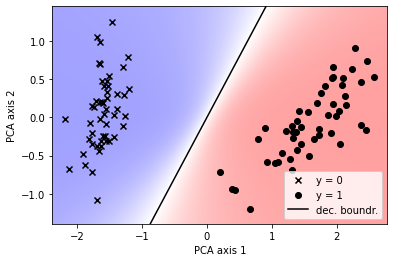

In [15]:
# Create grid
mplot = 500
xspace = np.linspace(x_lim_lower, x_lim_upper, mplot)
yspace = np.linspace(y_lim_lower, y_lim_upper, mplot)
xmesh, ymesh = np.meshgrid(xspace, yspace)

# mu and sigma2 (evaluated at grid)
mu = (M @ w)[0] * xmesh + (M @ w)[1] * ymesh
sigma2 = MSMT[0][0] * xmesh**2 + MSMT[0][1] * xmesh*ymesh \
            + MSMT[1][0] * xmesh*ymesh + MSMT[1][1]*ymesh**2

# Predictive distribution (evaluated at grid)
pred = norm().cdf(mu / np.sqrt(1 + sigma2))


# Decision boundary
vec = M @ w
yplot = - (vec[0] / vec[1]) * xspace

# Plot
plt.pcolormesh(xspace, yspace, pred, alpha=.5, vmin=0, vmax=1, cmap='bwr')
plt.scatter(pca.fit_transform(X)[:, 0][y == 0], pca.fit_transform(X)[:, 1][y == 0], 
            color='black', marker='x', label='y = 0')
plt.scatter(pca.fit_transform(X)[:, 0][y == 1], pca.fit_transform(X)[:, 1][y == 1], 
            color='black', label='y = 1')
plt.plot(xspace, yplot, color='black', label='dec. boundr.')
plt.xlim(x_lim_lower, x_lim_upper)
plt.ylim(y_lim_lower, y_lim_upper)

plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')
plt.legend(loc='lower right')
plt.show()